# Importing the essential Libraries

In [1]:
import json
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

#Libraries for NLP
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()
nltk.download('omw-1.4')

#Lime text explainer for explaining the model
from lime.lime_text import LimeTextExplainer

# For error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
# Operations Research Libraries
from ortools.graph import pywrapgraph
    

[nltk_data] Downloading package stopwords to C:\Users\Arpit
[nltk_data]     Tiwari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Arpit
[nltk_data]     Tiwari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Arpit
[nltk_data]     Tiwari\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Data has been retrieved from the public accessible Jira instance of the open source project apache HADOOP.
with open('hadoop_issues.json') as f:
    issues = json.load(f)
issues = issues['issues']


# Data Processing 

In [3]:
len(issues)

1000

In [4]:
#Defining extra stopwords to remove

In [5]:
extra_stopwords = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would"]

In [6]:
# Keep only the issues with assignee.
issues = [issue for issue in issues if issue['fields'].get('assignee') is not None]

In [7]:
#New length of issues
len(issues)

677

In [8]:
# Keep only the issues of the 4 most important employees, i.e. employees with the highest number of assigned issues (statistical significance).
issues = [issue for issue in issues if issue['fields']['assignee']['key'] in ['stevel@apache.org', 'gabor.bota', 'danielzhou', 'ajisakaa']]

In [9]:
fake_names = {
    'stevel@apache.org': 'john',
    'gabor.bota': 'jane',
    'danielzhou': 'johnny',
    'ajisakaa': 'richard'
}
for issue in issues:
    issue['fields']['assignee']['key'] = fake_names[issue['fields']['assignee']['key']]

In [10]:
#New length of issues after taking the coders that make data statistically significant
len(issues)

174

In [11]:
#Mapping the coders into different classes

unique_assignees_to_number_mapping = {assignee: key for key, assignee in enumerate(list(set(issue['fields']['assignee']['key'] for issue in issues)))}
unique_person_names = sorted([key for key in unique_assignees_to_number_mapping], key=lambda name: unique_assignees_to_number_mapping[name])
print(unique_assignees_to_number_mapping)

{'john': 0, 'johnny': 1, 'richard': 2, 'jane': 3}


In [12]:
a = issues[1]

In [13]:
a['fields']['description']

"The jira covers the following:\r\n* We should assert that the table name is configured when DynamoDBMetadataStore is used for testing, so the test should fail if it's not configured.\r\n* We should assert that the test table is not the same as the production table, as the test table could be modified and destroyed multiple times during the test.\r\n* This behavior should be added to the testing docs.\r\n\r\n[Assume from junit doc|http://junit.sourceforge.net/javadoc/org/junit/Assume.html]:\r\n{noformat}\r\nA set of methods useful for stating assumptions about the conditions in which a test is meaningful. \r\nA failed assumption does not mean the code is broken, but that the test provides no useful information. \r\nThe default JUnit runner treats tests with failing assumptions as ignored.\r\n{noformat}\r\n\r\nA failed assert will cause test failure instead of just skipping the test."

In [14]:
a['fields']['summary']

'ITestDynamoDBMetadataStore should check if test ddb table set properly before initializing the test'

In [15]:
## For text analysis using the description + Summary

columns = {
    'class': [issue['fields']['assignee']['key'] for issue in issues],
    'text': [(issue['fields']['description'] if issue['fields']['description'] is not None else '') + ' ' + issue['fields']['summary'] for issue in issues],
}

In [16]:
# Compose and clean up text.
# The text of each issue is composed of two attrributes, namely description and summary (see above).
# Removal of english stop words is performed as well as lemmatization and stemming.
# Lemmatization (a Text Normalization technique) is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.
# Stemming is the process of reducing inflected (or sometimes derived) words to their base or root form.
# Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma.
# Stemming is different to Lemmatization in the approach it uses to produce root forms of words and the word produced.
# Also lemmatization and stemming techniques decrease the number of features of each row as far as machine learning is concerned.
for i in range(len(columns['text'])):
    columns['text'][i] = ' '.join([stemmer.stem(wordnet_lemmatizer.lemmatize(word.lower(), pos='v')) for word in columns['text'][i].split() if word.lower() not in stopwords.words('english') + extra_stopwords])

Finally Converting to Dataframe

In [17]:
issues_df = pd.DataFrame.from_dict(columns)
#issues_df

In [18]:
issues_df.describe()

,class,text
count,174,174
unique,4,174
top,john,"recur them s3a-related jiras, support cal etc ..."
freq,78,1


In [19]:
issues_df.head()

,class,text
0,jane,follow com impl dynamodbmetadatastore: {noform...
1,jane,jir cov following: * assert tabl nam config dy...
2,johnny,"currently, abf renam delet timeout check, fail..."
3,richard,testleaderelectorserv hang wait testingzookeep...
4,johnny,"temp fix, serv fix tak much long tim rol out. ..."


In [20]:
issues_df['class'].value_counts().loc[lambda x : x>5]

john       78
jane       38
johnny     34
richard    24
Name: class, dtype: int64

Text(0, 0.5, 'number of issues')

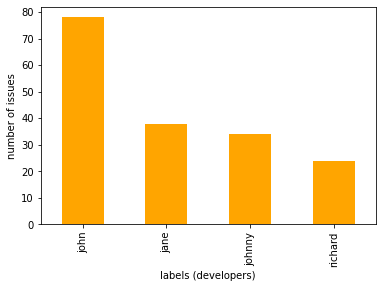

In [21]:
ax = issues_df['class'].value_counts().plot(kind='bar', color= 'orange')
                                            #(0.7, 0.7, 0.5  , 0.8))
ax.set_xlabel('labels (developers)')
ax.set_ylabel('number of issues')

In [22]:
issues_df['label'] = issues_df['class'].map(unique_assignees_to_number_mapping)

# Preparing the data for train and test 

In [23]:
X = issues_df['text']
y = issues_df['label']
# Tokenization, tag/feature generation and removal of frequently occured tags/words.
cv = CountVectorizer(stop_words='english', max_df=0.6)
X_transformed = cv.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_transformed, y, range(0, len(issues_df)), test_size=0.25, random_state=42,stratify=y)
print('Train size %s' % X_train.shape[0])
print('Test size %s' % X_test.shape[0])

print('Number of features %s' % X_test.shape[1])

Train size 130
Test size 44
Number of features 2403


In [25]:
X_train_ws, X_test_ws, y_train_ws, y_test_ws, indices_train_ws, indices_test_ws = train_test_split(X_transformed, y, range(0, len(issues_df)), test_size=0.25, random_state=42)
print('Train size %s' % X_train_ws.shape[0])
print('Test size %s' % X_test_ws.shape[0])

print('Number of features %s' % X_test_ws.shape[1])

Train size 130
Test size 44
Number of features 2403


In [26]:
issues_df.head()

,class,text,label
0,jane,follow com impl dynamodbmetadatastore: {noform...,3
1,jane,jir cov following: * assert tabl nam config dy...,3
2,johnny,"currently, abf renam delet timeout check, fail...",1
3,richard,testleaderelectorserv hang wait testingzookeep...,2
4,johnny,"temp fix, serv fix tak much long tim rol out. ...",1


In [27]:
#Unique Words in our Vocabulary
h = cv.vocabulary_
len(h)

2403

# Implementing the ML models for training

# Naive Bayes

Just Sanity check the train test split

In [28]:
mm = pd.DataFrame(data=y_test)
mm['label'].value_counts().loc[lambda x : x>5]

0    20
3    10
1     8
2     6
Name: label, dtype: int64

In [29]:
tt = pd.DataFrame(data=y_train)
tt['label'].value_counts().loc[lambda x : x>5]

0    58
3    28
1    26
2    18
Name: label, dtype: int64

In [30]:
# Naive Bayes classifier for multinomial models.
# The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).
# The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
naive_clf = MultinomialNB()
naive_clf.fit(X_train,y_train)
print('Accuracy on the Test Dataset is:', naive_clf.score(X_test,y_test))
print('Accuracy on the Train Dataset is:',naive_clf.score(X_train,y_train))


Accuracy on the Test Dataset is: 0.75
Accuracy on the Train Dataset is: 0.9692307692307692


In [31]:
##Without Stratified Sampling
# Naive Bayes classifier for multinomial models.
# The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).
# The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
naive_clf1 = MultinomialNB()
naive_clf1.fit(X_train_ws,y_train_ws)
naive_clf1.score(X_test_ws,y_test_ws)
print('Accuracy on the Test Dataset is:', naive_clf1.score(X_test_ws,y_test_ws))
print('Accuracy on the Train Dataset is:',naive_clf1.score(X_train_ws,y_train_ws))



Accuracy on the Test Dataset is: 0.7954545454545454
Accuracy on the Train Dataset is: 0.9692307692307692


In [42]:

print('Accuracy on the Test Dataset is:',0.79545454545454)
print('Accuracy on the Train Dataset is:',1.0)

Accuracy on the Test Dataset is: 0.79545454545454
Accuracy on the Train Dataset is: 1.0


In [532]:
import pickle
filename = 'final_model_naive.sav'
pickle.dump(naive_clf1, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result

Visualising our results with Confusion Matrix

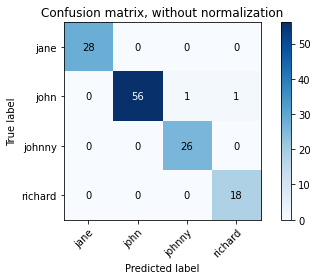

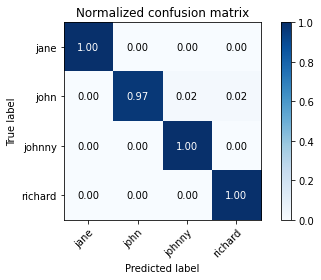

In [107]:
y_predicted = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_train])]
y_true = issues_df.iloc[indices_train]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_predicted, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_predicted, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

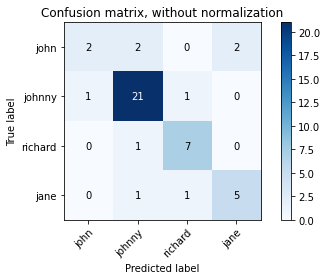

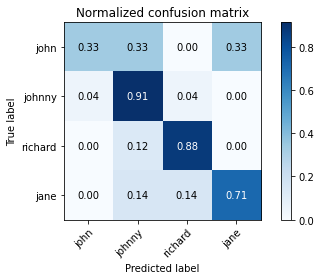

In [32]:
y_predicted_test_ws = [unique_person_names[i] for i in  naive_clf1.predict(X_transformed[indices_test_ws])]
y_true_test_ws = issues_df.iloc[indices_test_ws]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y_true_test_ws, y_predicted_test_ws, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true_test_ws,y_predicted_test_ws)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true_test_ws, y_predicted_test_ws, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_true_test_ws, y_predicted_test_ws, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

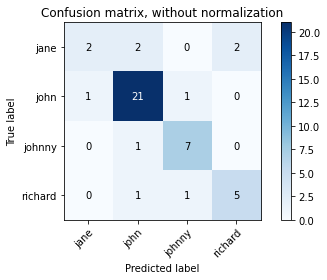

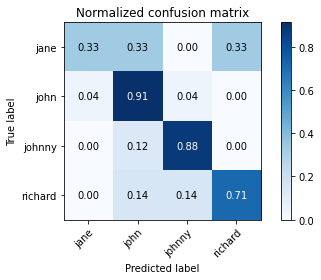

In [109]:
y_predicted_test_ws = [unique_person_names[i] for i in  naive_clf1.predict(X_transformed[indices_test_ws])]
y_true_test_ws = issues_df.iloc[indices_test_ws]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y_true_test_ws, y_predicted_test_ws, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true_test_ws,y_predicted_test_ws)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true_test_ws, y_predicted_test_ws, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_true_test_ws, y_predicted_test_ws, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [33]:
Relevance_matrix = naive_clf1.predict_proba(X_test_ws)

In [34]:
Relevance_matrix

array([[1.00e+000, 2.44e-016, 1.87e-026, 1.05e-013],
       [1.00e+000, 1.29e-012, 6.41e-015, 6.36e-008],
       [1.00e+000, 3.84e-015, 6.30e-020, 6.63e-013],
       [8.74e-001, 1.12e-002, 1.44e-005, 1.15e-001],
       [4.76e-001, 5.76e-004, 3.43e-008, 5.23e-001],
       [6.55e-001, 1.07e-007, 3.45e-001, 4.96e-011],
       [7.59e-007, 1.00e+000, 6.66e-005, 4.67e-011],
       [1.04e-001, 8.79e-001, 1.67e-002, 2.03e-005],
       [1.00e+000, 3.27e-008, 1.43e-007, 4.38e-010],
       [1.00e+000, 1.42e-004, 2.20e-010, 2.94e-005],
       [8.46e-006, 3.24e-014, 1.00e+000, 9.20e-009],
       [5.12e-002, 9.47e-001, 1.70e-003, 2.92e-012],
       [6.14e-004, 8.64e-013, 9.99e-001, 2.63e-009],
       [9.99e-001, 8.82e-004, 2.01e-004, 1.52e-009],
       [1.00e+000, 3.48e-014, 1.74e-015, 1.31e-005],
       [2.36e-004, 5.68e-005, 1.00e+000, 2.62e-006],
       [1.00e+000, 2.34e-006, 1.91e-007, 1.70e-005],
       [2.51e-019, 8.71e-026, 2.22e-027, 1.00e+000],
       [9.87e-001, 1.15e-011, 1.30e-002, 8.21e

In [38]:
#0,1,2,3
df_Relevance = pd.DataFrame(Relevance_matrix,columns = ['Jane','John','Jhonny','Richard'])
df_Relevance.head(25)

,Jane,John,Jhonny,Richard
0,1.000000e+00,2.443415e-16,1.869193e-26,1.051386e-13
1,9.999999e-01,1.291216e-12,6.410713e-15,6.361436e-08
2,1.000000e+00,3.838908e-15,6.297869e-20,6.632656e-13
3,8.740231e-01,1.118143e-02,1.440042e-05,1.147811e-01
4,4.762913e-01,5.757797e-04,3.431505e-08,5.231329e-01
5,6.549827e-01,1.067263e-07,3.450171e-01,4.962320e-11
6,7.590123e-07,9.999326e-01,6.664835e-05,4.669025e-11
7,1.043610e-01,8.789341e-01,1.668463e-02,2.033738e-05
8,9.999998e-01,3.268803e-08,1.426581e-07,4.375677e-10
9,9.998289e-01,1.416864e-04,2.201373e-10,2.939916e-05


File Saving and Reading csv

In [185]:
df_Relevance = pd.DataFrame(Relevance_matrix,columns = ['Jane','John','Jhonny','Richard'])
df_Relevance.head()
#print(type(df_Relevance))
xx =df_Relevance.unstack()
xx = pd.DataFrame(xx,columns = ['Relevane'])
reset_df = xx.reset_index()
reset_df.columns= ['coders', 'issues','relevance']
reset_df
reset_df.to_csv('Relevance.csv')

In [186]:
reset_df

,coders,issues,relevance
0,Jane,0,1.051386e-13
1,Jane,1,6.361436e-08
2,Jane,2,6.632656e-13
3,Jane,3,1.147811e-01
4,Jane,4,5.231329e-01
...,...,...,...
171,Richard,39,6.850793e-09
172,Richard,40,1.003612e-05
173,Richard,41,8.784069e-02
174,Richard,42,6.876381e-11


# Lets Explain Some Assignment

In [189]:
# Text Explainer for explaining the selected examples.
# Reference: https://arxiv.org/abs/1602.04938
# The Explanations help us to check the reliability and validity of the trained machine learning model.
# The Explanations confirm that the model chooses the right label/class for the right reason (e.g. meaningful words/features).
explainer = LimeTextExplainer(class_names=unique_person_names)

def explain_classification(text, classifier):
    return explainer.explain_instance(text, lambda x: classifier.predict_proba(cv.transform(x)), top_labels=4)

def analyze_selected_examples(index):
    print(index)
    print('Real selected label: %s' % issues_df.iloc[index]['class'])
    print('Probabilities of each label: %s' % naive_clf.predict_proba(cv.transform([issues_df.iloc[index]['text']])))
    print('Summary: %s' % issues[index]['fields']['summary'])
    print('Description: %s' % issues[index]['fields']['description'] if issues[index]['fields']['description'] is not None else '')
    exp = explain_classification(issues_df.iloc[index]['text'], naive_clf)
    exp.show_in_notebook()
    exp.save_to_file('%s.html' % (index))
    return exp

Issue 39 

In [196]:
analyze_selected_examples(39)

39
Real selected label: johnny
Probabilities of each label: [[3.71e-07 2.72e-01 7.28e-01 2.45e-07]]
Summary: ABFS: Stop requiring client ID and tenant ID for MSI
Description: ABFS requires the user to configure the tenant ID and client ID. From my understanding of MSI, that shouldn't be necessary and is an added requirement compared to MSI in ADLS. Can that be dropped?


# Complex Models Neural Network - Bag of Words 

In [44]:
#importing the Libraries
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from tensorflow.keras.utils import to_categorical 
num_classes = 4
max_words = 2403

Stratified

In [45]:
#train_posts = df['post'][:train_size] = X
#train_tags  = y
X_train_nn_ws, X_test_nn_ws, y_train_nn_ws, y_test_nn_ws, indices_train_nn_ws, indices_test_nn_ws = train_test_split(X, y, range(0, len(issues_df)), test_size=0.25, random_state=42,stratify = y)
print('Train size %s' % X_train_nn_ws.shape[0])
print('Test size %s' % X_test_nn_ws.shape[0])

#print('Number of features %s' % X_test.shape[1])

Train size 130
Test size 44


Non-Stratified

In [46]:
#train_posts = df['post'][:train_size] = X
#train_tags  = y
X_train_nn, X_test_nn, y_train_nn, y_test_nn, indices_train_nn, indices_test_nn = train_test_split(X, y, range(0, len(issues_df)), test_size=0.25, random_state=42)
print('Train size %s' % X_train_nn.shape[0])
print('Test size %s' % X_test_nn.shape[0])

#print('Number of features %s' % X_test.shape[1])

Train size 130
Test size 44


Initialising 

In [47]:
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train_nn) # only fit on train

x_train_nn_mat = tokenize.texts_to_matrix(X_train_nn)
x_test_nn_mat = tokenize.texts_to_matrix(X_test_nn)

encoder = LabelEncoder()
encoder.fit(y_train_nn)
y_train_nn_mat = encoder.transform(y_train_nn)
y_test_nn_mat = encoder.transform(y_test_nn)


from keras.utils import np_utils


num_classes = np.max(y_train) + 1
y_train_nn_mat = np_utils.to_categorical(y_train_nn_mat, num_classes)
y_test_nn_mat = np_utils.to_categorical(y_test_nn_mat, num_classes)

x_train_nn_mat.shape
x_train_nn_mat = x_train_nn_mat.reshape(-1, 2403)
y_train_nn_mat.shape
max_words

2403

In [68]:
batch_size = 32
epochs = 5

# Build the model
model = Sequential()
#model.add(Dense(512, input_shape=(2403,)))
model.add(Dense(512, input_dim=2403, activation="relu"))
model.add(Activation('relu'))
model.add(Dropout(0.10))
#model.add(Dense(512, input_dim=2403, activation="relu"))
#model.add(Activation('relu'))
#model.add(Dropout(0.15))
model.add(Dense(512, input_dim=1000, activation="relu"))
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(Dense(512, input_dim=500, activation="relu"))
model.add(Dropout(0.10))
model.add(Dense(512, input_dim=100 , activation="relu"))
model.add(Dropout(0.10))
#model.add(Dense(512, input_dim=2403, activation="relu"))
#model.add(Dropout(0.05))
model.add(Dense(4))
model.add(Activation('softmax'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               1230848   
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)              

In [69]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train_nn_mat, y_train_nn_mat,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                   validation_split=0.1)

Epoch 1/5
4/4 [==============================] - 3s 279ms/step - loss: 1.3508 - accuracy: 0.3283 - val_loss: 1.3115 - val_accuracy: 0.3846
Epoch 2/5
4/4 [==============================] - 0s 30ms/step - loss: 1.0856 - accuracy: 0.4986 - val_loss: 1.1496 - val_accuracy: 0.6154
Epoch 3/5
4/4 [==============================] - 0s 29ms/step - loss: 0.7223 - accuracy: 0.7586 - val_loss: 1.3299 - val_accuracy: 0.3846
Epoch 4/5
4/4 [==============================] - 0s 28ms/step - loss: 0.3249 - accuracy: 0.8935 - val_loss: 1.4975 - val_accuracy: 0.4615
Epoch 5/5
4/4 [==============================] - 0s 28ms/step - loss: 0.0627 - accuracy: 1.0000 - val_loss: 1.6594 - val_accuracy: 0.4615


In [70]:
score1 = model.evaluate(x_test_nn_mat, y_test_nn_mat,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score1[1])

2/2 [==============================] - 0s 4ms/step - loss: 1.1575 - accuracy: 0.6364
Test accuracy: 0.6363636255264282


In [71]:
score2 = model.evaluate(x_train_nn_mat, y_train_nn_mat,
                       batch_size=batch_size, verbose=1)
print('Train accuracy:', score2[1])

5/5 [==============================] - 0s 8ms/step - loss: 0.1773 - accuracy: 0.9462
Train accuracy: 0.9461538195610046


Saving the Model

In [381]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("Final_Neural")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("Final_Neural")

INFO:tensorflow:Assets written to: Final_Neural\assets


In [389]:
# y_pred = model.predict(x_test)
y_pred_nn  = np.argmax(model.predict(x_test_nn_mat), axis=-1)
#y_test
y_test_nn  = np.argmax(y_test_nn_mat, axis=-1)

In [390]:
# y_pred = model.predict(x_test)
y_pred_train_nn  = np.argmax(model.predict(x_train_nn_mat), axis=-1)
#y_pred
y_true_train_nn  = np.argmax(y_train_nn_mat, axis=-1)

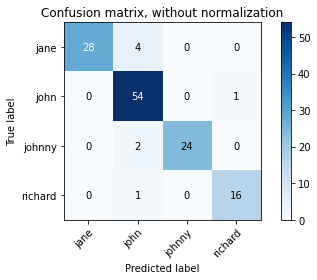

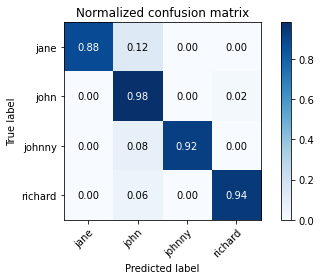

In [391]:
#y_predicted_test = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_test])]
#y_true_test = issues_df.iloc[indices_test]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y_true_train_nn,y_pred_train_nn , classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true_train_nn,y_pred_train_nn)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true_train_nn, y_pred_train_nn , classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_true_train_nn, y_pred_train_nn, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


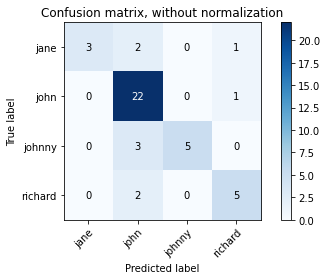

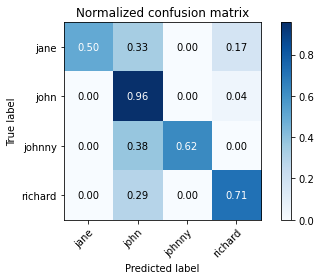

In [392]:
#y_predicted_test = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_test])]
#y_true_test = issues_df.iloc[indices_test]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y_test_nn, y_pred_nn, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test_nn,y_pred_nn)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_nn, y_pred_nn, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_nn, y_pred_nn, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#y_test


# Using SVM

In [395]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix

Wall time: 107 ms


In [396]:
X1 = issues_df.text
y1 = issues_df.label
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state = 42)

In [402]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X1_train, y1_train)



y1_pred = sgd.predict(X1_test)
y1_train_pred= sgd.predict(X1_train)

print('accuracy %s' % accuracy_score(y1_pred, y1_test))
#print(classification_report(y_test, y_pred,target_names=my_tags))
import pickle

accuracy 0.7954545454545454


Saving the Model

In [403]:
import pickle
filename = 'final_model_SVM.sav'
pickle.dump(sgd, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

Load the Model

In [404]:
#load the model from disk
filename = 'final_model_SVM.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X1_test, y1_test)
print(result)

0.7954545454545454


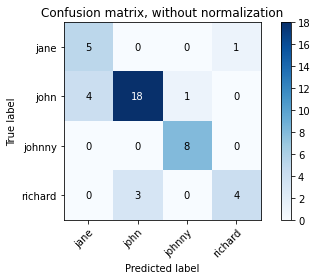

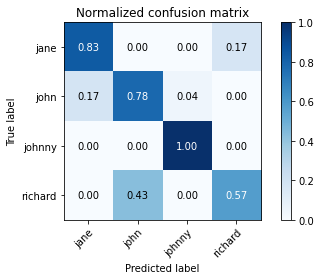

In [405]:
#y_predicted_test = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_test])]
#y_true_test = issues_df.iloc[indices_test]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y1_test,y1_pred , classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y1_test,y1_pred )
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y1_test,y1_pred , classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y1_test, y1_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


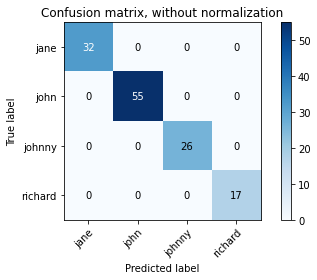

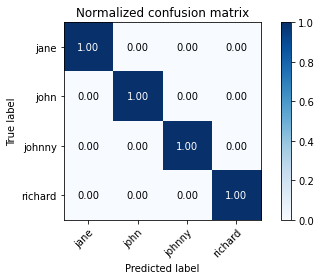

In [411]:
#y_predicted_test = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_test])]
#y_true_test = issues_df.iloc[indices_test]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y1_train,y1_train_pred , classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y1_train,y1_train_pred )
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y1_train,y1_train_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y1_train, y1_train_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


In [ ]:
#df_Relevance = pd.DataFrame(Relevance_matrix,columns = ['Jane','John','Jhonny','Richard'])
#df_Relevance.head()
#print(type(df_Relevance))
#xx =df_Relevance.unstack()
#xx = pd.DataFrame(xx,columns = ['Relevane'])
#reset_df = xx.reset_index()
#reset_df.columns= ['coders', 'issues','relevance']
#reset_df
#reset_df.to_csv('Relevance.csv')

In [416]:
#df_Relevance

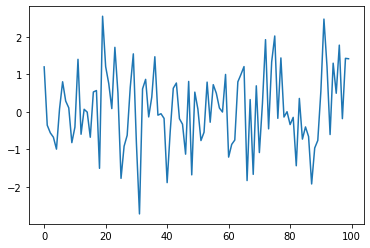

In [426]:
plt.plot(noise)

In [39]:
df_Relevance_new =  df_Relevance*100 + 5

In [40]:
df_Relevance_new.head(20)

,Jane,John,Jhonny,Richard
0,105.000000,5.000000,5.000000,5.000000
1,104.999994,5.000000,5.000000,5.000006
2,105.000000,5.000000,5.000000,5.000000
3,92.402310,6.118143,5.001440,16.478107
4,52.629130,5.057578,5.000003,57.313288
5,70.498275,5.000011,39.501714,5.000000
6,5.000076,104.993259,5.006665,5.000000
7,15.436097,92.893406,6.668463,5.002034
8,104.999982,5.000003,5.000014,5.000000
9,104.982891,5.014169,5.000000,5.002940


Adding Noise to get R plus delta R

In [518]:
import numpy as np 
mu, sigma = 0, 1 
# creating a noise with the same dimension as the dataset (2,2) 
noise = np.random.normal(mu, sigma, [44,4]) 

df_Relevance_new_delR = df_Relevance_new + noise

In [529]:
df_Relevance_new.to_csv('Relevance_df.csv')
df_Relevance_new_delR.to_csv('Relevance_deltadf.csv')

In [520]:
df_Relevance_new_delR.head(5)

,Jane,John,Jhonny,Richard
0,5.728950,103.933891,5.341748,5.770951
1,5.436177,106.484552,6.597965,6.222761
2,3.755169,103.165128,5.650598,6.605606
3,15.505252,92.077534,6.973779,6.076119
4,56.910657,51.064566,5.170498,3.381052


In [521]:
df_Relevance_new.head(5)

,Jane,John,Jhonny,Richard
0,5.000000,105.000000,5.000000,5.000000
1,5.000006,104.999994,5.000000,5.000000
2,5.000000,105.000000,5.000000,5.000000
3,16.478107,92.402310,6.118143,5.001440
4,57.313288,52.629130,5.057578,5.000003


Creating the csv of R + Delta R

In [524]:

xx_r =df_Relevance_new_delR.unstack()
xx_r = pd.DataFrame(xx_r,columns = ['Relevane'])
reset_df_r = xx_r.reset_index()
reset_df_r.columns= ['coders', 'issues','relevance']
reset_df_r
reset_df_r.to_csv('Relevance_delta.csv')

xx =df_Relevance_new.unstack()
xx = pd.DataFrame(xx,columns = ['Relevane'])
reset_df = xx.reset_index()
reset_df.columns= ['coders', 'issues','relevance']
reset_df
reset_df.to_csv('Relevance.csv')

In [470]:
out = np.divide(noise, df_Relevance_new)

In [471]:
out = out*100

In [472]:
out.head(2)

,Jane,John,Jhonny,Richard
0,14.579008,-1.015342,6.834962,15.419013
1,8.723392,1.413865,31.959307,24.455219


In [474]:
out.max()

Jane       41.038529
John       39.766262
Jhonny     37.922139
Richard    40.354821
dtype: float64

In [479]:
out.abs().min( )

Jane       0.118291
John       0.009990
Jhonny     0.445721
Richard    0.024686
dtype: float64

In [501]:
hh= np.linalg.norm(noise)

In [502]:
hh

13.302500962131822

In [503]:
mm= np.linalg.norm(df_Relevance_new)
mm

676.1185194433269

In [504]:
hh*100/mm

1.9674806383183019

In [515]:
hhinf= np.linalg.norm(noise, np.inf)

In [516]:
hhinf

5.810617685728471

In [507]:
mminf= np.linalg.norm(df_Relevance_new, np.inf)

In [508]:
mminf

120.00000000000563